In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['newdrivingdata']


In [2]:
print (os.listdir('../input/newdrivingdata/newdrivingdata/'))

['test', 'steering_angle.csv', 'train']


In [3]:
import pandas as pd
df = pd.read_csv('../input/newdrivingdata/newdrivingdata/steering_angle.csv', header = None)
print (df.head(3))
split_index = int(len(df)*0.8)
train_df = df[:split_index]
test_df = df[split_index:]
print (train_df.shape)
print (test_df.shape)

       0    1
0  0.jpg  0.0
1  1.jpg  0.0
2  2.jpg  0.0
(36324, 2)
(9082, 2)


In [4]:
train_df.columns = ["image","angle"]
test_df.columns = ['image','angle']
print (train_df.head(3))
print (test_df.head(3))

   image  angle
0  0.jpg    0.0
1  1.jpg    0.0
2  2.jpg    0.0
           image  angle
36324  36324.jpg -11.09
36325  36325.jpg -10.79
36326  36326.jpg -10.08


In [5]:
test_df = test_df.reset_index(drop=True)
test_df.head(3)

,image,angle
0,36324.jpg,-11.09
1,36325.jpg,-10.79
2,36326.jpg,-10.08


In [6]:
import numpy as np 
import math 
test_df.angle = np.deg2rad(test_df.angle)
train_df.angle = np.deg2rad(train_df.angle)
test_df.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(9082, 2)

In [7]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [8]:
shift = 0.2
datagen = ImageDataGenerator(rescale = 1./255 , rotation_range = 5 , width_shift_range=shift, 
                             height_shift_range=shift,validation_split = 0.25)

In [9]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/newdrivingdata/newdrivingdata/train/",
    x_col="image",
    y_col="angle",
    has_ext=True,                                     
    subset="training",
    batch_size=100,
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=(100,100))






Found 27243 images.


In [10]:
valid_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/newdrivingdata/newdrivingdata/train/",
    x_col="image",
    y_col="angle",
    has_ext=True,                                     
    subset="validation",
    batch_size=100,
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=(100,100))



Found 9081 images.


In [11]:
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D
from keras.regularizers import l2
from keras.optimizers import SGD, Adam, RMSprop
import sklearn.metrics as metrics


model = Sequential()
#1st conv layer
model.add(Conv2D(24,(5,5) ,strides=(2,2),input_shape=(100,100,3), activation='relu',
                 kernel_regularizer=l2(0.001)))
#2nd conv layer
model.add(Conv2D(36, (5,5),strides=(2,2), activation='relu',kernel_regularizer=l2(0.001)))
#3rd conv layer
model.add(Conv2D(48, (5,5),strides=(2,2), activation='relu',kernel_regularizer=l2(0.001)))
#4th conv layer
model.add(Conv2D(64, (3,3), activation='relu',kernel_regularizer=l2(0.001)))
#5th conv layer
model.add(Conv2D(64, (3,3), activation='relu',kernel_regularizer=l2(0.001)))
# flatten
model.add(Flatten())
# FC layers
model.add(Dense(1164, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
# adam optimizer
adam = Adam(lr=0.0001)
model.compile(optimizer = adam ,loss="mse")
model.summary()
          

 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 48)          43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1164)              1863564   
__________

In [12]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30
)

Epoch 1/30
272/272 [==============================] - 251s 923ms/step - loss: 0.3340 - val_loss: 0.7473
Epoch 2/30
272/272 [==============================] - 172s 633ms/step - loss: 0.2624 - val_loss: 0.6977
Epoch 3/30
272/272 [==============================] - 173s 637ms/step - loss: 0.2275 - val_loss: 0.7183
Epoch 4/30
272/272 [==============================] - 171s 627ms/step - loss: 0.2038 - val_loss: 0.7004
Epoch 5/30
272/272 [==============================] - 174s 641ms/step - loss: 0.1902 - val_loss: 0.6755
Epoch 6/30
272/272 [==============================] - 172s 632ms/step - loss: 0.1753 - val_loss: 0.7588
Epoch 7/30
272/272 [==============================] - 172s 631ms/step - loss: 0.1650 - val_loss: 0.7702
Epoch 8/30
272/272 [==============================] - 172s 633ms/step - loss: 0.1551 - val_loss: 0.8002
Epoch 9/30
272/272 [==============================] - 172s 633ms/step - loss: 0.1488 - val_loss: 0.7974
Epoch 10/30
272/272 [==============================] - 172s 633m

In [13]:
model.evaluate_generator(generator = valid_generator , steps =STEP_SIZE_VALID )

0.7969196558250854

In [14]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="../input/newdrivingdata/newdrivingdata/test/",
    x_col="image",
    y_col=None,
    has_ext=True,
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(100,100))

Found 9082 images.


In [15]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
pred=model.predict_generator(test_generator,STEP_SIZE_TEST,verbose=1)

9082/9082 [==============================] - 248s 27ms/step


In [16]:
import keras
from keras import losses
mse = keras.losses.mean_squared_error(test_df.angle, pd.DataFrame(pred))


In [17]:
print (mse)

Tensor("Mean:0", shape=(9082,), dtype=float64)


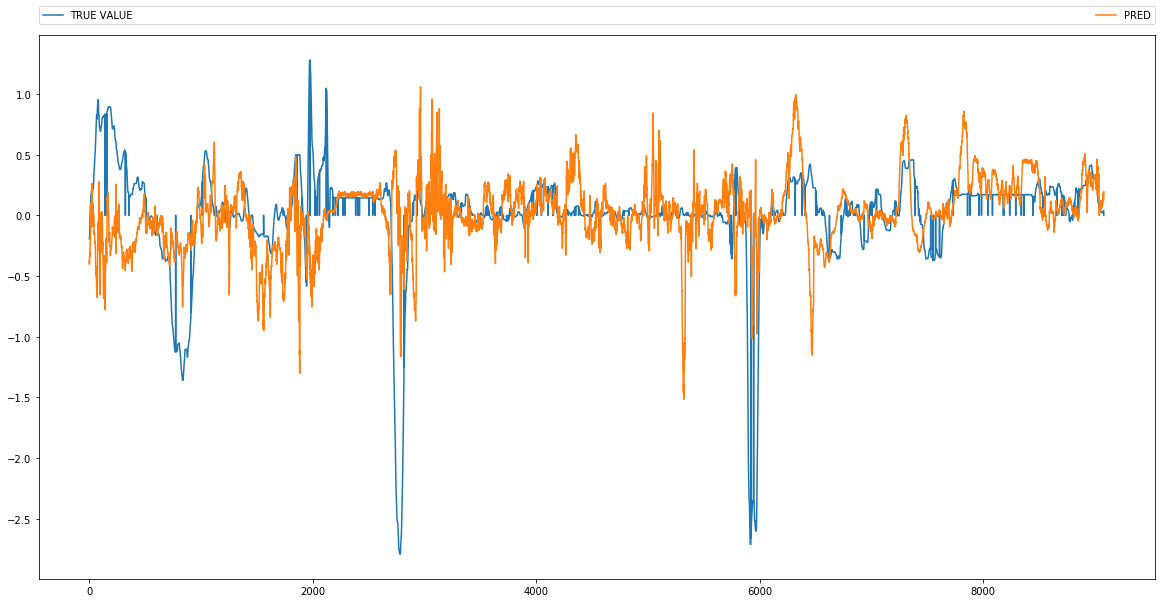

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt



plt.figure(figsize=(20,10))
plt.plot(test_df.angle, label = 'TRUE VALUE')
plt.plot(pred, label = "PRED")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()